# Uber: identify hot zones in New York City
- Objective: Create an algorithhm to dentify hot zones for ride pickups in NYC. Create clusters and identify their characteristics, in order to reduce customer waiting time. Visualize the results in a city map.

Link to Storyboard:

https://public.tableau.com/app/profile/david.garcia3078/viz/UberRidesStoryboard/UberStoryboard

![New York Boroughs](https://www.worldatlas.com/r/w768/upload/c6/23/73/shutterstock-152208935.jpg)

## Imports
- Data Exploration

In [1]:
# data handling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import datetime

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

##### Map
The New York Area will be considered as the southwest end of Staten Island, the north end of the Bronx and the eastern end of Queens.


- __Latitude__: 40.5479 to 40.8673
- __Longitude__: -74.0374 to -73.7467

In [2]:
# vscode 

taxi = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/taxi-zone-lookup.csv")
april_14 = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/uber-raw-data-apr14.csv")
may_14 = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/uber-raw-data-may14.csv")
june_14 = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/uber-raw-data-jun14.csv")
july_14 = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/uber-raw-data-jul14.csv")
august_14 = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/uber-raw-data-aug14.csv")
sept_14 = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/uber-raw-data-sep14.csv")

# not used, as it does not contain latitudess and longitudes
# jan_june_15 = pd.read_csv("/Users/student/Desktop/UnsupervisedML_Uber/uber-trip-data/.uber-raw-data-janjune-15.csv")

In [3]:
# display 5 samples of each dataframe
frames = [taxi, april_14, may_14, june_14, july_14, august_14, sept_14] # , jan_june_15]

for frame in frames:
    print("Shape:", frame.shape)
    display(frame.head())
    # add space
    print()

Shape: (265, 3)


,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights



Shape: (564516, 4)


,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512



Shape: (652435, 4)


,Date/Time,Lat,Lon,Base
0,5/1/2014 0:02:00,40.7521,-73.9914,B02512
1,5/1/2014 0:06:00,40.6965,-73.9715,B02512
2,5/1/2014 0:15:00,40.7464,-73.9838,B02512
3,5/1/2014 0:17:00,40.7463,-74.0011,B02512
4,5/1/2014 0:17:00,40.7594,-73.9734,B02512



Shape: (663844, 4)


,Date/Time,Lat,Lon,Base
0,6/1/2014 0:00:00,40.7293,-73.9920,B02512
1,6/1/2014 0:01:00,40.7131,-74.0097,B02512
2,6/1/2014 0:04:00,40.3461,-74.6610,B02512
3,6/1/2014 0:04:00,40.7555,-73.9833,B02512
4,6/1/2014 0:07:00,40.6880,-74.1831,B02512



Shape: (796121, 4)


,Date/Time,Lat,Lon,Base
0,7/1/2014 0:03:00,40.7586,-73.9706,B02512
1,7/1/2014 0:05:00,40.7605,-73.9994,B02512
2,7/1/2014 0:06:00,40.7320,-73.9999,B02512
3,7/1/2014 0:09:00,40.7635,-73.9793,B02512
4,7/1/2014 0:20:00,40.7204,-74.0047,B02512



Shape: (829275, 4)


,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512



Shape: (1028136, 4)


,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


## Feature Engineering

Data from april '14 to september '14 all contain the same variables, those frames will be joined. This dataframe will be used from now on.

- Data Types
- Duplicates & Missing Values
- Data Transformations
- Filters & Masks

In [4]:
# join dataframes
frames = april_14, may_14, june_14, july_14, august_14, sept_14
df = pd.concat(frames)
df.sample(5)

,Date/Time,Lat,Lon,Base
431735,6/26/2014 20:28:00,40.7542,-73.9825,B02617
57392,5/3/2014 13:34:00,40.7671,-73.9619,B02598
169870,6/17/2014 15:57:00,40.7441,-73.9839,B02598
195913,4/28/2014 20:08:00,40.7551,-73.9765,B02598
688770,9/6/2014 16:12:00,40.6898,-73.9801,B02682


In [5]:
df.shape

(4534327, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


In [7]:
# change "base" to category
df["Base"] = df["Base"].astype("category")

In [8]:
# change date to datetime
df["Date/Time"] = pd.to_datetime(df["Date/Time"])
df["Date/Time"].head()

0   2014-04-01 00:11:00
1   2014-04-01 00:17:00
2   2014-04-01 00:21:00
3   2014-04-01 00:28:00
4   2014-04-01 00:33:00
Name: Date/Time, dtype: datetime64[ns]

In [9]:
# create individual columns for date and time for exploratory analysis
df["Day"] = df["Date/Time"].dt.day
df["Month"] = df["Date/Time"].dt.month
df["Year"] = df["Date/Time"].dt.year
df["Time"] = df["Date/Time"].dt.hour

# drop Date/Time column
df.drop(columns="Date/Time", inplace=True)

df.head()

,Lat,Lon,Base,Day,Month,Year,Time
0,40.7690,-73.9549,B02512,1,4,2014,0
1,40.7267,-74.0345,B02512,1,4,2014,0
2,40.7316,-73.9873,B02512,1,4,2014,0
3,40.7588,-73.9776,B02512,1,4,2014,0
4,40.7594,-73.9722,B02512,1,4,2014,0


In [10]:
# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 1028135
Data columns (total 7 columns):
 #   Column  Dtype   
---  ------  -----   
 0   Lat     float64 
 1   Lon     float64 
 2   Base    category
 3   Day     int32   
 4   Month   int32   
 5   Year    int32   
 6   Time    int32   
dtypes: category(1), float64(2), int32(4)
memory usage: 177.3 MB


In [11]:
# missing values
df.isna().sum()

Lat      0
Lon      0
Base     0
Day      0
Month    0
Year     0
Time     0
dtype: int64

In [12]:
# duplicates
df.duplicated().sum()

112842

In [13]:
# percentage of duplicates
(df.duplicated().sum()  / len(df)) * 100

2.4886162819752524

In [14]:
# drop duplicates
df.drop_duplicates(inplace=True)

# sanity check
df.duplicated().sum()

0

In [15]:
# filter for latitude and longitude, to obtain observations only for NYC

# set values for minimum and maximum latitudes and longitudes
min_lat = 40.5479
max_lat = 40.8673
min_lon = -74.0374
max_lon = -73.7467

# latitude and longitude mask
df = df[(df["Lat"] >= min_lat) & (df["Lon"] >= min_lon) & \
 (df["Lon"] >= min_lon) & (df["Lon"] <= max_lon)]

df.shape

(4333854, 7)

## Exploratory Data Analysis
- Relationships
- Value Counts
- Statistics
- Visualizations

<Axes: >

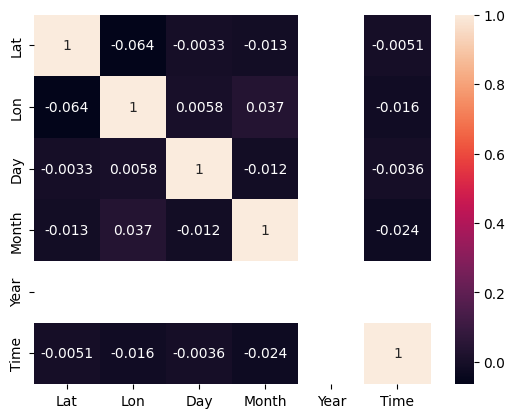

In [16]:
sns.heatmap(df.select_dtypes("number").corr(), annot=True)

- Very low correlation between our variables, that is a good thing.

In [17]:
print("Average latitude", round(df["Lat"].mean(),2))

Average latitude 40.74


In [18]:
print("Average longitude", round(df["Lon"].mean(),2))

Average longitude -73.97


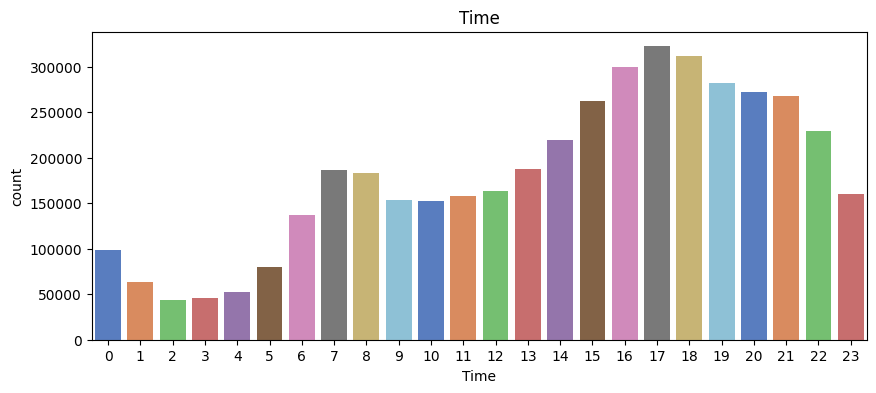

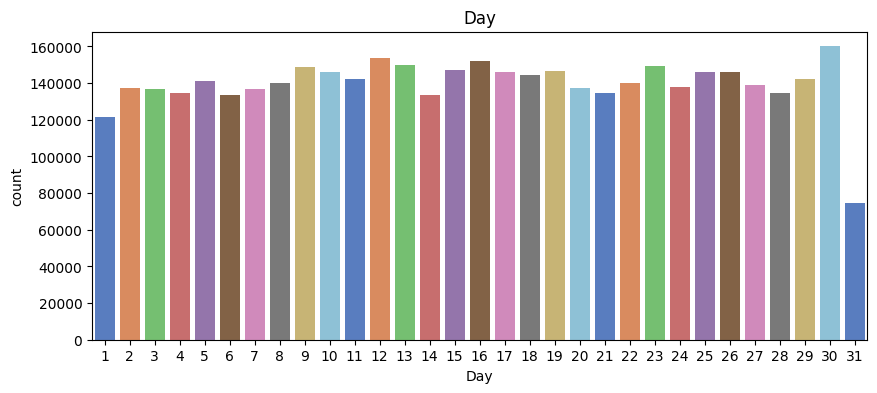

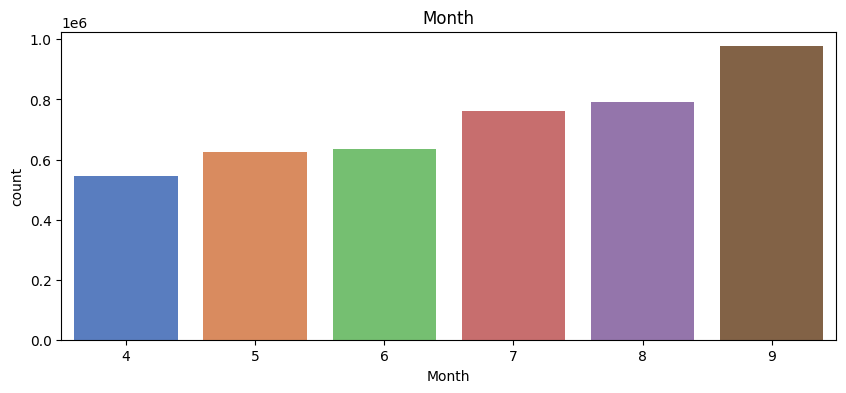

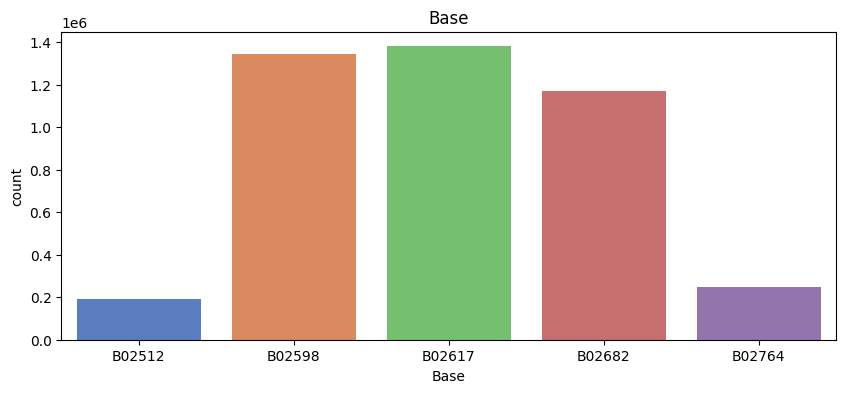

In [19]:
# for loop to create countplot for selected variables

cols = ["Time", "Day", "Month", "Base"]

for col in cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df,
                  x=col,
                  palette="muted")
    plt.title(col)
    plt.show()

##### Insight
- There is, a relationship regarding time of the day. Logically Uber rides are at its highes during peak times of the day, that is between 15 and 21 hours.
- There is, in the other hand, no specific pattern regarding the day of the month in relationship to quantity of Uber rides.
- There are half of uber rides the 31st of the month, but it is a logical assumption knowing that april, june and september all have 30 days. 
- Uber rides rose throughout the year, with September having around double sales than April.
- Bases B02598 and B02617 are most used, while B02764 and B02512 are barely used.

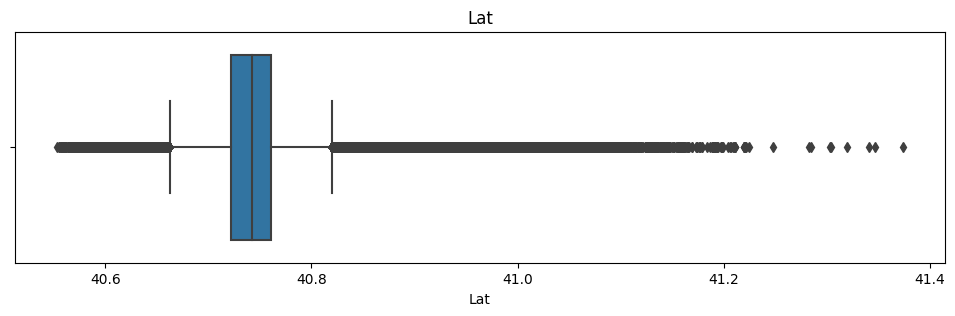

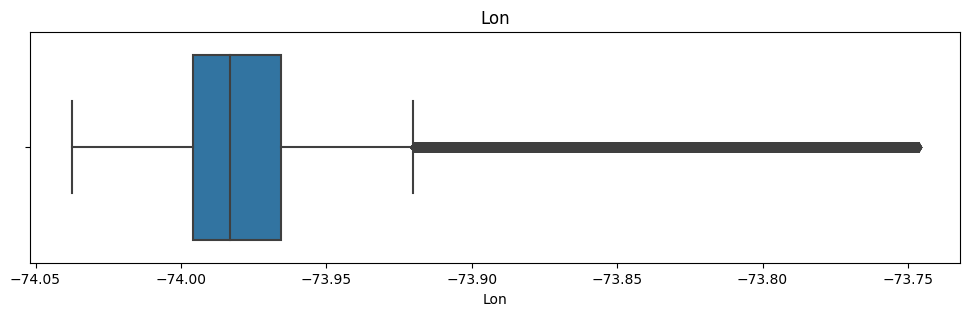

In [20]:
# for loop to create boxplot for selected variables

cols = ["Lat", "Lon"]

for col in cols:
    plt.figure(figsize=(12,3))
    sns.boxplot(data=df,
            x=col)
    plt.title(col)
    plt.show()

##### Insight
- Uber rides are far more concentrated latitudwise than longitudwise. In other words, Uber rides are spread far more from North to South than West to East.
- Most of Uber rides are located on Manhattan, containing more than half.

## Machine Learning
- To create clusters we will use the K Means algorithm.
- DBSCAN was tried, but given that our data and the algorithm's time complexity are of considerable size, it was decided to stick with K-Means only.

### Preprocessing
- No target variable, only "X" variable will be created.
- Variables considered will be Latitude and Longitude, the rest are not necessary (Time will be used, but not for now).
- Normalization of features.


In [21]:
X = df[["Lat", "Lon"]]
# "Day", "Month", "Hour", "Minute", "Base"]
X.head()

,Lat,Lon
0,40.7690,-73.9549
1,40.7267,-74.0345
2,40.7316,-73.9873
3,40.7588,-73.9776
4,40.7594,-73.9722


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4333854 entries, 0 to 1028135
Data columns (total 2 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Lat     float64
 1   Lon     float64
dtypes: float64(2)
memory usage: 99.2 MB


In [23]:
# X will be converted to an array when normalized
# columns will be saved in order to be able to create labeled graphs
X_cols = list(X.columns)
X_cols

['Lat', 'Lon']

In [24]:
# normalize X
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# visualize random sample
X_norm[48]

array([-0.42820183, -0.89239922])

### K-Means
- Fit baseline model
- Look at data and decide optimal number of clusters

In [25]:
# fit baseline model
kmeans = KMeans(random_state=42)
kmeans.fit(X_norm)

KMeans(random_state=42)

In [26]:
# create cluster centers, or the average of each cluster
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
display(cluster_centers)

array([[ 40.75542455, -73.98245154],
       [ 40.71087643, -73.94638794],
       [ 40.65068749, -73.78715278],
       [ 40.76284322, -73.86664731],
       [ 40.726483  , -73.99917664],
       [ 40.78218263, -73.95869251],
       [ 40.8832608 , -73.89296622],
       [ 40.67050728, -73.97804211]])

In [27]:
# try different number of clusters, from 1 to 10
# mean distortions = average euclidean distance

clusters = range(1, 10)
mean_distortions = []

# make loop to find ideal number of clusters
for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(X_norm)
    # assign clusters
    pred = model.predict(X_norm)
    mean_distortions.append(
        sum(
            np.min(cdist(X, model.cluster_centers_, "euclidean"), axis=1)
        ) 
        / pd.DataFrame(X).shape[0]
    )

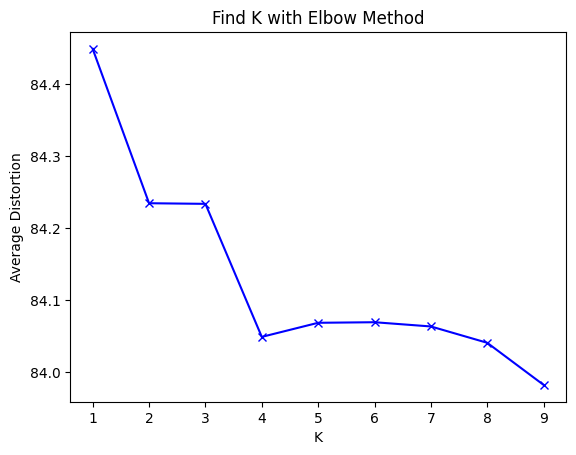

In [28]:
# average euclidean distance from centroid
plt.plot(clusters, mean_distortions, "bx-")
plt.xlabel("K")
plt.ylabel("Average Distortion")
plt.title("Find K with Elbow Method")
plt.show()

- It seems like our optimal number of clusters is four.
- There is a minimal difference between four and nine, the next best option, but it increases complexity and interpretability, so it is best to stick with four.

#### K-Means 4

In [29]:
# make predictions and assign clusters to observations
kmeans_4 = KMeans(n_clusters=4, random_state=0)
kmeans_4.fit(X_norm)
kmeans_4_pred = kmeans_4.predict(X_norm)

X["kmeans_4_cluster"] = kmeans_4_pred
X.head()

,Lat,Lon,kmeans_4_cluster
0,40.7690,-73.9549,1
1,40.7267,-74.0345,0
2,40.7316,-73.9873,0
3,40.7588,-73.9776,1
4,40.7594,-73.9722,1


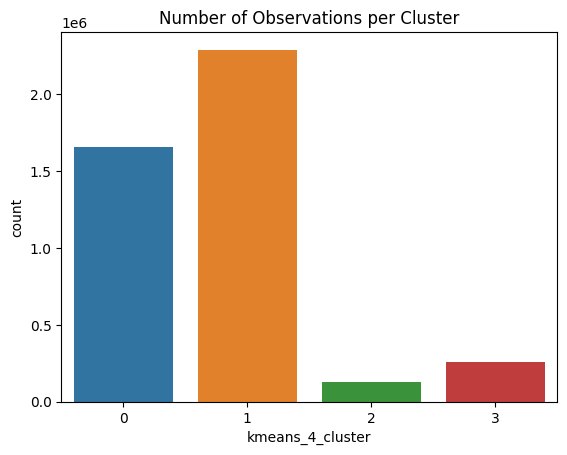

In [30]:
sns.countplot(data=X,
              x="kmeans_4_cluster")
plt.title("Number of Observations per Cluster")
plt.show()

In [31]:
X["kmeans_4_cluster"].value_counts(1).round(2)

kmeans_4_cluster
1    0.53
0    0.38
3    0.06
2    0.03
Name: proportion, dtype: float64

In [32]:
# average latitude and longitude for each cluster
X.groupby("kmeans_4_cluster").mean()

,Lat,Lon
kmeans_4_cluster,,
0,40.711342,-73.987487
1,40.757978,-73.980403
2,40.657299,-73.794100
3,40.797438,-73.894089


In [33]:
# centroids for model
kmeans_4_clusters = scaler.inverse_transform(kmeans_4.cluster_centers_)
display(kmeans_4_clusters)

array([[ 40.7112658 , -73.98746485],
       [ 40.75791263, -73.98044785],
       [ 40.65732141, -73.79408245],
       [ 40.79743005, -73.89430428]])

In [34]:
# download csv file, send it to tableau
# X.to_csv("kmeans_4_clusters.csv")

##### Insight:
**Look at Storyboard**

- Four main clusters were identified, which are:

      - Cluster 0 (Blue): Lower Manhattan & Midwest Brooklyn
      - Cluster 1 (Yellow): Western Queens & The Bronx
      - Cluster 2 (Red): Eastern Brooklyn & Eastern Queens
      - Cluster 3 (Green): Midtown & Upper Manhattan

- Clusters 0 and 3 are the ones with the most traffic, accounting with 53% and 38% of Uber rides each. That makes up for an astonishing 91% between both of them.
- This comes as no surprise, as both of these clusters include areas of Manhattan, which is one of the busiest zones not only in the United States but in the world.

### Clustering with Time
- The previous algorithm was done with only the latitude and longitudes, we will now include time.
- Day is not included, as we found no pattern on the exploratory data analysis. 

#### Preprocessing

In [35]:
df.head()

,Lat,Lon,Base,Day,Month,Year,Time
0,40.7690,-73.9549,B02512,1,4,2014,0
1,40.7267,-74.0345,B02512,1,4,2014,0
2,40.7316,-73.9873,B02512,1,4,2014,0
3,40.7588,-73.9776,B02512,1,4,2014,0
4,40.7594,-73.9722,B02512,1,4,2014,0


In [36]:
# declare X with new variables
X = df[["Lat", "Lon","Time"]]
X.head()

,Lat,Lon,Time
0,40.7690,-73.9549,0
1,40.7267,-74.0345,0
2,40.7316,-73.9873,0
3,40.7588,-73.9776,0
4,40.7594,-73.9722,0


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4333854 entries, 0 to 1028135
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Lat     float64
 1   Lon     float64
 2   Time    int32  
dtypes: float64(2), int32(1)
memory usage: 115.7 MB


In [38]:
# X will be converted to an array when normalized
# columns will be saved in order to be able to create labeled graphs
X_cols = list(X.columns)
X_cols

['Lat', 'Lon', 'Time']

In [39]:
# normalize X
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# visualize random sample
X_norm[101]

array([-0.40936937, -0.68473499, -1.21171748])

#### Clustering

##### Baseline K-Means

In [40]:
# fit model
kmeans = KMeans(random_state=0)
kmeans.fit(X_norm)

KMeans(random_state=0)

In [41]:
# cluster centers
# create cluster centers, or the average of each cluster
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
print(f"Amount of clusters: {len(cluster_centers)} \n")
print("Centroids:")
display(cluster_centers)

Amount of clusters: 8 

Centroids:


array([[ 40.72406879, -73.98807726,   5.54943142],
       [ 40.76293304, -73.97482867,  18.00876341],
       [ 40.65079527, -73.78721273,  14.73993564],
       [ 40.76617585, -73.9726119 ,   9.13034255],
       [ 40.72831335, -73.99618974,  18.05334765],
       [ 40.86879503, -73.90397719,  13.82432521],
       [ 40.67674297, -73.96632232,  15.69277374],
       [ 40.76204106, -73.86787502,  14.81659116]])

In [42]:
# make predictions
pred = kmeans.predict(X_norm)
X["baseline_clusters"] = pred
X.head()

,Lat,Lon,Time,baseline_clusters
0,40.7690,-73.9549,0,3
1,40.7267,-74.0345,0,0
2,40.7316,-73.9873,0,0
3,40.7588,-73.9776,0,0
4,40.7594,-73.9722,0,0


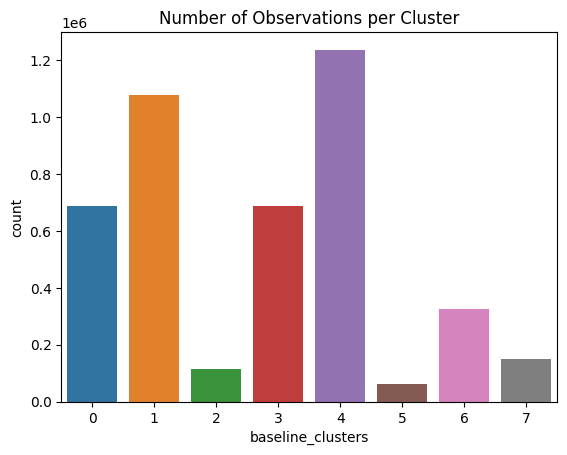

In [43]:
sns.countplot(data=X,
              x="baseline_clusters")
plt.title("Number of Observations per Cluster")
plt.show()

In [44]:
X["baseline_clusters"].value_counts(1).round(2)

baseline_clusters
4    0.29
1    0.25
3    0.16
0    0.16
6    0.07
7    0.03
2    0.03
5    0.01
Name: proportion, dtype: float64

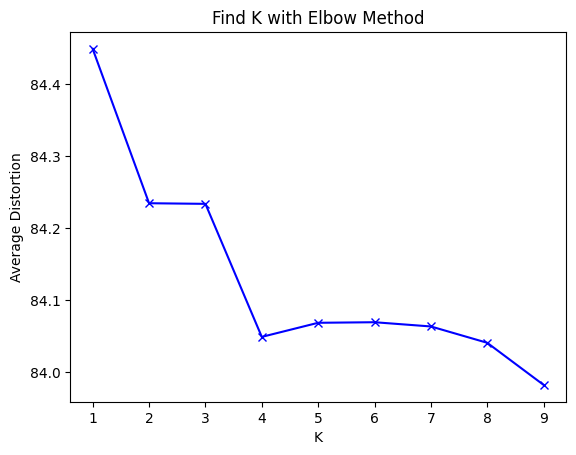

In [45]:
# average euclidean distance from centroid
plt.plot(clusters, mean_distortions, "bx-")
plt.xlabel("K")
plt.ylabel("Average Distortion")
plt.title("Find K with Elbow Method")
plt.show()

##### Insight
- It is basically the same as our previous baseline model, nothing really changed, so we will proceed the same way and apply K=4.

##### K=4, with Time variable

In [46]:
# fit model
kmeans_4_time = KMeans(n_clusters=4, random_state=42)
kmeans_4_time.fit(X_norm)

KMeans(n_clusters=4, random_state=42)

In [47]:
# make cluster predictions
pred = kmeans_4_time.predict(X_norm)
X["kmeans_4_time_clusters"] = pred
X.head()

,Lat,Lon,Time,baseline_clusters,kmeans_4_time_clusters
0,40.7690,-73.9549,0,3,1
1,40.7267,-74.0345,0,0,1
2,40.7316,-73.9873,0,0,1
3,40.7588,-73.9776,0,0,1
4,40.7594,-73.9722,0,0,1


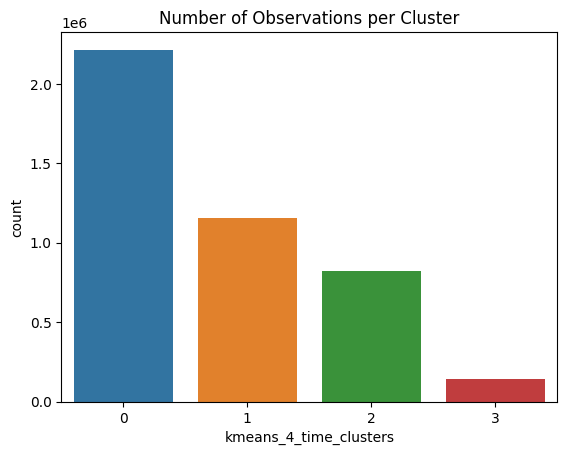

In [48]:
sns.countplot(data=X,
              x="kmeans_4_time_clusters")
plt.title("Number of Observations per Cluster")
plt.show()

In [49]:
# percentage of observations per cluster
X["kmeans_4_time_clusters"].value_counts(1).round(2)

kmeans_4_time_clusters
0    0.51
1    0.27
2    0.19
3    0.03
Name: proportion, dtype: float64

In [50]:
# drop columns, leave only those used in algorithm
# group by clusters
X.drop(columns=["baseline_clusters"], inplace=True)
X.groupby(by="kmeans_4_time_clusters").mean()


,Lat,Lon,Time
kmeans_4_time_clusters,,,
0,40.734184,-73.987479,18.265423
1,40.728740,-73.984494,6.969394
2,40.782442,-73.944645,13.402179
3,40.662737,-73.799983,14.674039


In [51]:
# fin
clusters = [0, 1, 2, 3]
percentage_of_rides = {"0-5": [0, 7.88, 0.66, 0.33],
                      "6-11": [0, 16.08, 5.8, 0.55],
                      "12-17": [21.08, 2.73, 8.62, 1.13],
                      "18-23": [30.02, 0, 3.85, 1.27]}

division_proposal = pd.DataFrame.from_dict(percentage_of_rides, orient="index", columns=clusters)
division_proposal

,0,1,2,3
0-5,0.00,7.88,0.66,0.33
6-11,0.00,16.08,5.80,0.55
12-17,21.08,2.73,8.62,1.13
18-23,30.02,0.00,3.85,1.27


In [52]:
# download csv file, send it to tableau
# X.to_csv("kmeans_4_time_clusters.csv")

##### Insight

**Look at Storyboard**

- Four main clusters were identified, which are:

      - Cluster 0 (Blue): Middle and Lower Manhattan & West Brookly, between 0 and 11:59 hours
      - Cluster 1 (Yellow): Middle and Lower Manhattan & West Brookly, between 12 and 23:59 hours
      - Cluster 2 (Red): West Queens, Upper Manhattan & The Bronx, between 6 and 23:59 hours
      - Cluster 3 (Green): Eastern Brooklyn & Eastern Queens, between 12 and 23:59

- It is really similar to clusters without Time, as the division of zones are similar. The only difference would be time, since the blue and yellow clusters overlap as they cover the same area, but yellow is in the morning and blue is after midday. The red cluster practically disappears before 6, as well as green before 12.


## Recommendations and Conclusions

This is a very evident example of the Pareto Principle: we now know that around 90% of rides are located on Manhattan: which represents way less than 20% of the area. Uber rides are highly concentrated. It is also true that a little more than 70% of rides happen between 12 and 23:59.

After analysis, the best way to take advantage of this phenomenon is to **divide Uber drivers by cluster, or by time and zone**:

In [53]:
division_proposal

,0,1,2,3
0-5,0.00,7.88,0.66,0.33
6-11,0.00,16.08,5.80,0.55
12-17,21.08,2.73,8.62,1.13
18-23,30.02,0.00,3.85,1.27


- This is the percentage of drivers that would be allocated to each cluster in terms of area.

Coordinates by area:

    Blue (0) and Yellow:
        - 
        Northwest:40.8132, -73.9668
        Northeast: 40.8030, -73.9086
        Southwest: 40.5811, -740588
        Southeast: 40.5754, -739415

    Green (2):
        Northwest: 40.9111, -73.9101
        Northeast: 40.8711, -73.7494
        Southwest: 40.7735, -73.9571
        Southeast: 40.6965, -73.8103
    

    Red (3):
        Northwest: 40.7961, -73.8895
        Northeast: 40.8665, -73.7123
        Southwest: 40.5318, -73.9490
        Southeast: 40.5499, -73.7548

_Note: coordinates are accurate but not exact, they are approximates of the area each cluster covers. They do overlap in some cases and can even be covering water._

In [54]:
# division by cluster
division_proposal.sum()

0    51.10
1    26.69
2    18.93
3     3.28
dtype: float64

- Around 90% of drivers would be in the Manhattan zone

- This is the percentage of drivers that would be allocated to each cluster in terms of time group:

In [55]:
# division by time group
division_proposal.T.sum()

0-5       8.87
6-11     22.43
12-17    33.56
18-23    35.14
dtype: float64

- Almost 70% of drivers would work from 12 to midnight

### Possible ideas for future exploration:
- Traffic on Weekends
- Fares
- Direction of each ride
- Duration of ride